<a href="https://colab.research.google.com/github/AntoninaKOR/RL/blob/main/DQN_and_its_Improvings_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading and Importing

In [ ]:
!pip install Image
!pip install gymnasium

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 34.9 MB/s eta 0:00:00
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=2a51b8f9fbf804ea0c3cf63951de813d392918e625a101ef7259dbb7e0012314
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built Image
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 38.5 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
from torch.distributions import Categorical
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
import random

import matplotlib.pyplot as plt
%matplotlib inline

import sys

from tqdm import trange, tqdm

In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

#Intro
There is a **DGN** algorithms. The algorithm works on CatPole environment from Gymnasium lib.

The **task** is to implement the algorithm and train the model.

Information is taken from  the book "Foundations of Deep Reinforcement Learning: Theory and Practice in Python" (Addison-Wesley Data & Analytics Series) and same parts of the code is taken with changes from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

#Env

Initial observation:


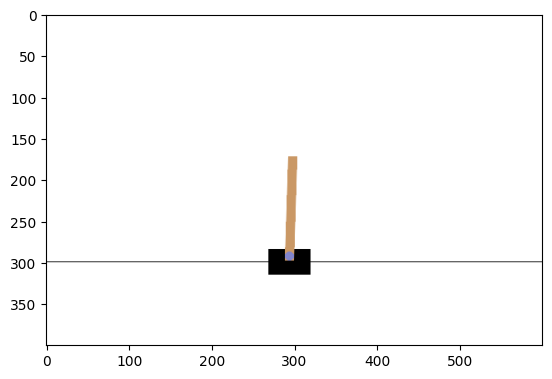

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
print("Initial observation:")
plt.imshow(env.render())

#Memory
There is a deque where is placed batch of pairs (s, a, s').

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#DQN

##Algorithm

We use algorithm from the book "Foundations of Deep Reinforcement Learning: Theory and Practice in Python" (Addison-Wesley Data & Analytics Series).

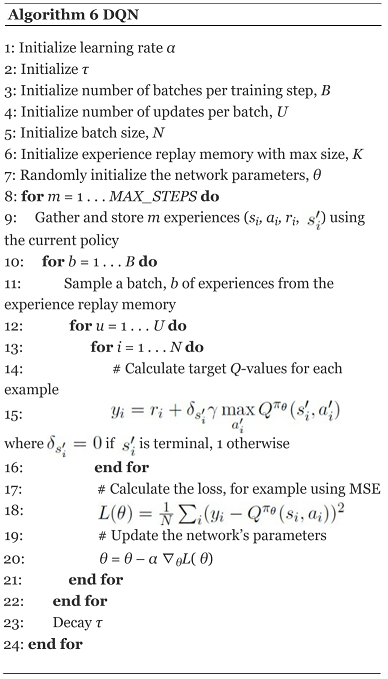

##Q-value model

Here we use DL for Q-value, not a table.

In [ ]:
# Q-value model
class Q(nn.Module):
  def __init__(self, in_dim, out_dim,  gamma):
    super(Q, self).__init__()
    layers = [ nn.Linear(n_observations, 128),
              nn.Linear(128, 128),
               nn.Linear(128, n_actions)
               ]

    self.model = nn.Sequential(*layers)
    self.gamma = gamma

  def forward(self, x):
    pdparam = self.model(x)
    return pdparam

  def train (self):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-terminal states and concatenate the batch elements
    # It is delta from the algorithm.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.zeros((BATCH_SIZE, 4), device=device)
    next_state_batch[non_final_mask] = non_final_next_states.clone()
    # Compute Q(s, a)
    q_preds = self(state_batch)
    state_action_values = q_preds.gather(1, action_batch.unsqueeze(0))

    # Compute max Q(s', a')
    q_target = self.calc_target(next_state_batch)
    # Compute target Q-value
    y = reward_batch + self.gamma*q_target*non_final_mask
    # Compute loss
    loss = nn.MSELoss(reduction= 'mean')
    q_loss = loss(state_action_values, y)

    # Optimize the model
    optimizer.zero_grad()
    q_loss.backward()
    optimizer.step()

  def calc_target(self, states):
    return torch.max(self(states), 1).values



## The Boltzmann Policy


This function choose random action by Boltzmann distribution. So, the agent better discover the enviroment.

In [ ]:
def policy_boltzmann(state, t , Q):
  softmax = nn.Softmax()
  r = softmax(Q(state/t))
  pd = Categorical(probs=r)
  action = pd.sample()
  return action.item()

##Main loop

In [65]:
BATCH_SIZE = 500
GAMMA = 0.99
T = 5
LR = 1e-4
NUM_BATCHES = 10
N = 200 # number of epochs
rewards=[]
steps=[]

# Get number of actions from gym action space
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
memory = ReplayMemory(BATCH_SIZE*4)

Q_net = Q(n_observations, n_actions, GAMMA).to(device)

optimizer = optim.AdamW(Q_net.parameters(), lr=LR, amsgrad=True)

for i_episode in trange(N, file=sys.stdout):
    st =0
    for i_batch in range(NUM_BATCHES):
      state, info = env.reset()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      for t in range(BATCH_SIZE):
          action = policy_boltzmann(state ,T, Q_net)
          new_s, reward, terminated, truncated, _ = env.step(action)
          reward = torch.tensor([reward], device=device)
          action = torch.tensor([action], device=device)
          done = terminated or truncated

          if terminated:
              next_state = None
          else:
              next_state = torch.tensor(new_s, dtype=torch.float32, device=device).unsqueeze(0)

          # Store the transition in memory
          memory.push(state, action, reward, next_state)

          # Move to the next state
          state = next_state

          if done:
            st += t+1.
            break

        # Perform one step of the optimization (on the policy network)
      Q_net.train()
    steps.append( st/BATCH_SIZE)
    tqdm.write(f'Episode {i_episode}, count of steps:{st/NUM_BATCHES}')


Episode 0, count of steps:22.9
Episode 1, count of steps:26.5
Episode 2, count of steps:21.1
Episode 3, count of steps:23.3
Episode 4, count of steps:18.4
Episode 5, count of steps:21.8
Episode 6, count of steps:18.2
Episode 7, count of steps:23.8
Episode 8, count of steps:20.1
Episode 9, count of steps:16.5
Episode 10, count of steps:22.4
Episode 11, count of steps:23.2
Episode 12, count of steps:15.8
Episode 13, count of steps:25.8
Episode 14, count of steps:16.7
Episode 15, count of steps:20.7
Episode 16, count of steps:19.8
Episode 17, count of steps:25.3
Episode 18, count of steps:24.3
Episode 19, count of steps:18.9
Episode 20, count of steps:18.4
Episode 21, count of steps:16.9
Episode 22, count of steps:19.7
Episode 23, count of steps:25.6
Episode 24, count of steps:18.5
Episode 25, count of steps:23.0
Episode 26, count of steps:26.3
Episode 27, count of steps:22.8
Episode 28, count of steps:25.8
Episode 29, count of steps:24.6
Episode 30, count of steps:21.5
Episode 31, count 

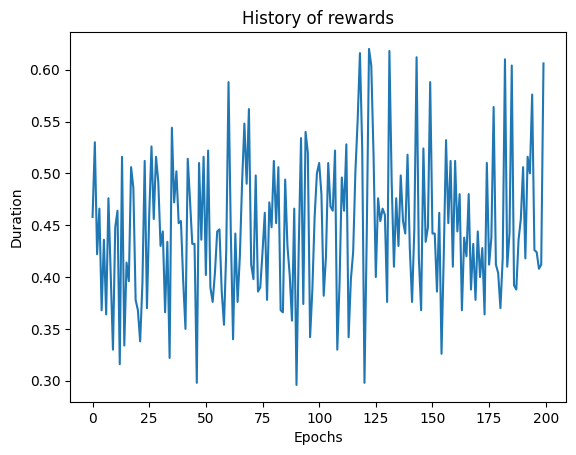

In [66]:
plt.plot(steps)
plt.title("History of rewards")
plt.xlabel("Epochs")
plt.ylabel("Duration")
plt.show()

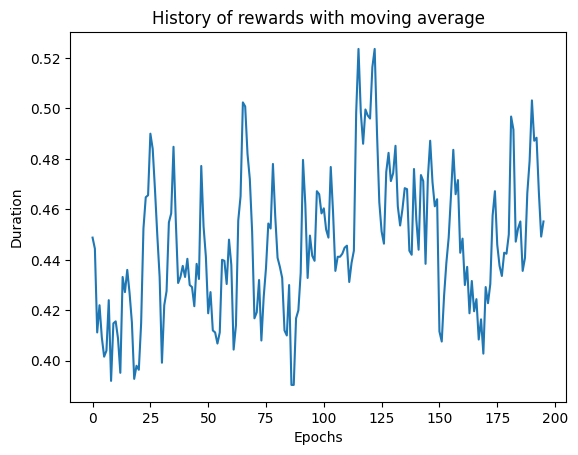

In [67]:
plt.plot([(steps[i]+steps[i-1]+ steps[i+1] + steps[i+2] + steps[i-2])/5 for i in range(2, len(steps)-2)])
plt.title("History of rewards with moving average")
plt.xlabel("Epochs")
plt.ylabel("Duration")
plt.show()

##Let's look have the agent acts

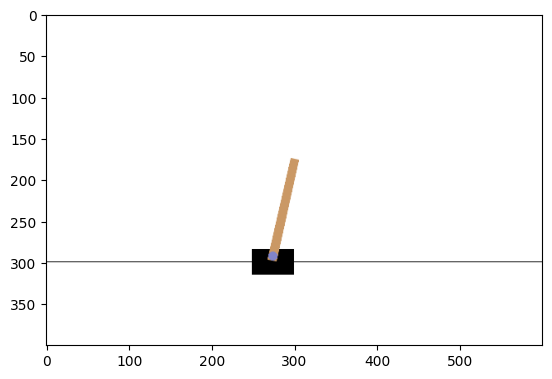

In [ ]:
from IPython import display
state, _ = env.reset()
for t in range(500):
  action = policy_boltzmann(torch.tensor(state, dtype=torch.float).unsqueeze(0) ,T, Q_net)
  new_s, r, terminated, truncated, _ = env.step(action)
  plt.imshow(env.render())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if terminated or truncated:
    break

#DQN with a target network

##Algorithm

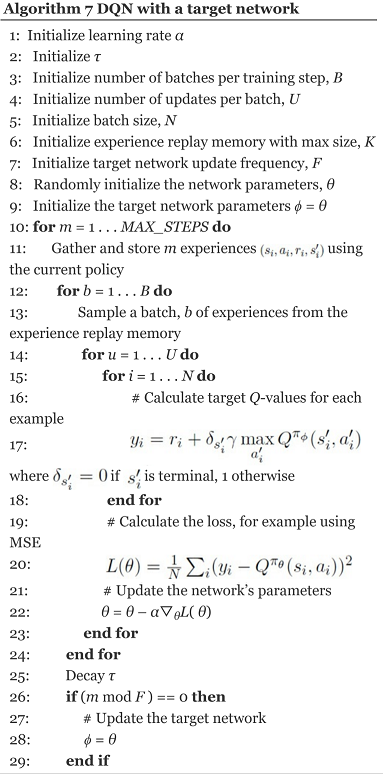

##Q-value model

In [69]:
class DQN_target(Q):
  def __init__(self, in_dim, out_dim,  gamma, target=None):
    super().__init__(in_dim, out_dim,  gamma)
    self.target = target
 #there is replacement update, not polyak ipdate
  def update_target(self):
    self.target.model.load_state_dict(self.model.state_dict())

  def calc_target(self, states):
    return torch.max(self.target(states), 1).values

#q_target = self.target_Q.calc_target(next_state_batch[non_final_mask])

##Main loop

In [70]:
f = 5 #target network update frequency, F
BATCH_SIZE = 500
GAMMA = 0.99
T = 5
LR = 1e-4
NUM_BATCHES = 10
N = 300 # number of epochs
rewards=[]
steps=[]

# Get number of actions from gym action space
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

Q_target = DQN_target(n_observations, n_actions, GAMMA ).to(device)
Q_net = DQN_target(n_observations, n_actions, GAMMA, Q_target).to(device)

optimizer = optim.AdamW(Q_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(BATCH_SIZE*NUM_BATCHES)


for i_episode in trange(N, file=sys.stdout):
    st =0
    for i_batch in range(NUM_BATCHES):
      state, info = env.reset()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      for t in range(BATCH_SIZE):
          action = policy_boltzmann(state ,T, Q_net)
          new_s, reward, terminated, truncated, _ = env.step(action)
          reward = torch.tensor([reward], device=device)
          action = torch.tensor([action], device=device)
          done = terminated or truncated

          if terminated:
              next_state = None
          else:
              next_state = torch.tensor(new_s, dtype=torch.float32, device=device).unsqueeze(0)

          # Store the transition in memory
          memory.push(state, action, reward, next_state)

          # Move to the next state
          state = next_state

          if done:
            st += t+1.
            break

        # Perform one step of the optimization (on the policy network)
      Q_net.train()

    if i_episode % f == 0:
      Q_net.update_target()

    steps.append( st/BATCH_SIZE)
    tqdm.write(f'Episode {i_episode}, count of steps:{st/NUM_BATCHES}')

Episode 0, count of steps:17.5
Episode 1, count of steps:21.4
Episode 2, count of steps:18.1
Episode 3, count of steps:20.3
Episode 4, count of steps:23.9
Episode 5, count of steps:24.0
Episode 6, count of steps:18.5
Episode 7, count of steps:20.5
Episode 8, count of steps:20.1
Episode 9, count of steps:19.1
Episode 10, count of steps:13.5
Episode 11, count of steps:25.5
Episode 12, count of steps:16.9
Episode 13, count of steps:24.8
Episode 14, count of steps:19.8
Episode 15, count of steps:20.1
Episode 16, count of steps:33.0
Episode 17, count of steps:25.3
Episode 18, count of steps:21.9
Episode 19, count of steps:20.7
Episode 20, count of steps:23.7
Episode 21, count of steps:19.9
Episode 22, count of steps:28.4
Episode 23, count of steps:21.9
Episode 24, count of steps:29.4
Episode 25, count of steps:20.6
Episode 26, count of steps:21.3
Episode 27, count of steps:27.6
Episode 28, count of steps:16.8
Episode 29, count of steps:22.3
Episode 30, count of steps:20.4
Episode 31, count 

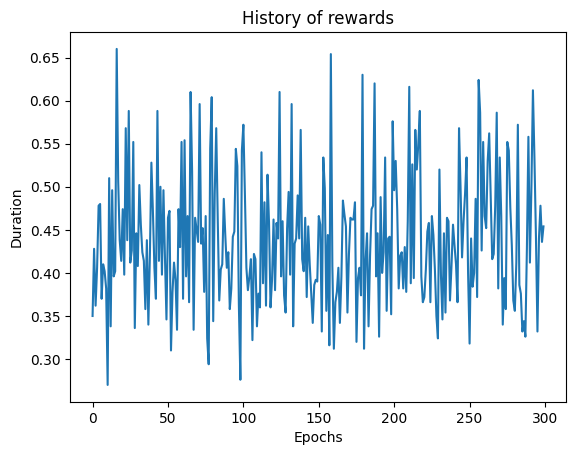

In [71]:
plt.plot(steps)
plt.title("History of rewards")
plt.xlabel("Epochs")
plt.ylabel("Duration")
plt.show()

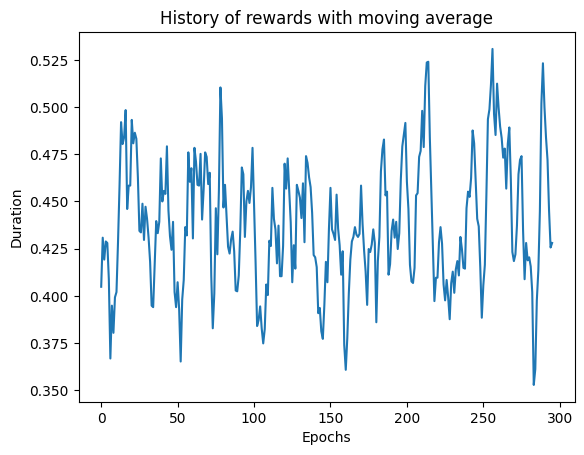

In [72]:
plt.plot([(steps[i]+steps[i-1]+ steps[i+1] + steps[i+2] + steps[i-2])/5 for i in range(2, len(steps)-2)])
plt.title("History of rewards with moving average")
plt.xlabel("Epochs")
plt.ylabel("Duration")
plt.show()

##Let's look how the agent acts

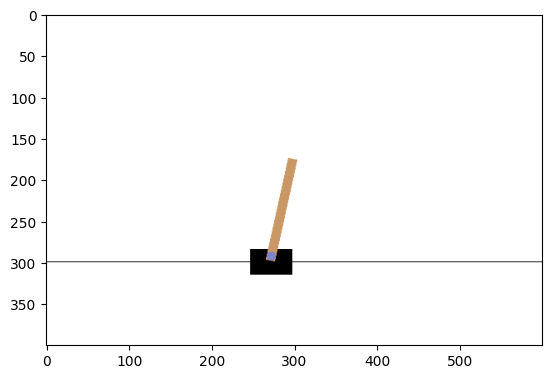

In [73]:
state, _ = env.reset()
for t in range(500):
  action = policy_boltzmann(torch.tensor(state, dtype=torch.float).unsqueeze(0) ,T, Q_net)
  new_s, r, terminated, truncated, _ = env.step(action)
  plt.imshow(env.render())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if terminated or truncated:
    break

#Double DQN